# Data collection 
## for measuring the coefficient of drag of a pickleball

## imports

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Functions - visualization

In [ ]:
def view_frame(frame, h=10, w=12):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(h, w))
    plt.imshow(frame_rgb)
    plt.gca().xaxis.set_ticks_position('both')
    plt.tick_params(top=True, labeltop=True)
    plt.show()

In [ ]:
def show_frames_side_by_side(frame1, frame2, title1='Frame 1', title2='Frame 2'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 10))
    
    frame1_rgb = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    frame2_rgb = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
    
    ax1.imshow(frame1_rgb)
    ax1.set_title(title1)
    ax1.axis('on')
    ax1.xaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(top=True, labeltop=True)

    ax2.imshow(frame2_rgb)
    ax2.set_title(title2)
    ax2.axis('on')
    ax2.xaxis.set_ticks_position('both')
    ax2.tick_params(top=True, labeltop=True)
    
    plt.tight_layout()
    plt.show()

## Functions - cv2 frame space

In [ ]:
def get_frame(cap, n):
    cap.set(cv2.CAP_PROP_POS_FRAMES, n)
    r, f = cap.read()
    t = elapsed_time(cap)
    return r, f, t

def elapsed_time(cap):
    return cap.get(cv2.CAP_PROP_POS_MSEC)

# ********************* operations on frames ****************
# Mask range for a ball
lower_yellow_green = np.array([30, 40, 40])
upper_yellow_green = np.array([80, 255, 255])

def convert_to_hsv(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

def masked(hsv_frame, lower, upper):
    return cv2.inRange(hsv_frame, lower, upper)

def get_mask(cap, n):
    ret, frame_n, t = get_frame(cap, n)
    hsv_n = convert_to_hsv(frame_n)
    mask_n = masked(hsv_n, lower_yellow_green, upper_yellow_green)
    return mask_n, t

def detect(mask):
    # Find centroid
    # cx, cy = get_moments(mask)
    
    # Find contours and fit circle for radius
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(largest_contour)
        radius = int(radius)
    else:
        radius = 0
    return x, y, radius

def add_circle(frame, x, y, r, circle_color = (0, 255, 0), centroid_color = (255, 0, 0)):
    result = frame.copy()
    cv2.circle(result, (x,y), r, circle_color, 2)  # Green circle
    cv2.circle(result, (x,y), 5, centroid_color, -1)  # Blue centroid dot
    
    return result

# ************************* Problem domain operations *****************
def find_ball(cap, n):
    ret, frame_n, t = get_frame(cap, n)
    if not ret: return False
    mask_n, t = get_mask(cap, n)
    x, y, r = detect(mask_n)
    print(f"{n:2d}, {t:7.2f}, {x:7.2f}, {y:7.2f}, {r:3d}")
    return True
    
def get_trajectory_data(cap, n):
    ret, frame_n, t = get_frame(cap, n)
    if not ret: 
        return n, np.nan, np.nan, np.nan, np.nan
    mask_n, t = get_mask(cap, n)
    x, y, r = detect(mask_n)
    return n, t, r, x, y
    

# ************ No longer used - replaced by findContours ************
# 
# def get_moments(msk):
#     moments = cv2.moments(msk)
#     cx = int(moments['m10'] / moments['m00'])
#     cy = int(moments['m01'] / moments['m00'])
#     return cx, cy


## Data location

In [ ]:
freefall_path = "../data/freefall.mp4"


## Capture video

In [ ]:
cap = cv2.VideoCapture(freefall_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Approximately {frame_count} frames at {fps} frames / second")
print(f"geometry width {frame_width} - height {frame_height}")

Approximately 74 frames at 54.7087743509494 frames / second
geometry width 2160 - height 3840


## Metrics to convert from "frame space" to feet
From `../calibration.ipynb`
- Pixels per inch x direction: 39.47
- Pixels per inch y direction: 39.44


In [ ]:

pixels_per_inch = (39.47 + 39.44) / 2
pixels_to_inches = 1 / pixels_per_inch
pixels_to_feet = pixels_to_inches / 12
pixels_per_inch, pixels_to_inches, pixels_to_feet

(39.455, 0.025345330122924854, 0.002112110843577071)

## Collect trajectory data

In [ ]:
# data = []
# for n in range(74):
#     n, t, r, x, y = get_trajectory_data(cap, n)
#     data.append([n, t, r, x, y])
# print("done")

In [ ]:
import pandas as pd

data = []
for n in range(36,63):
    n, t, r, x, y = get_trajectory_data(cap, n)
    x *= pixels_to_feet
    y *= pixels_to_feet
    r *= pixels_to_inches
    data.append({'frame': n, 'time': t, 'radius': r, 'x': x, 'y': y})

df = pd.DataFrame(data)

## Calculate velocity and acceleration components

In [ ]:
# time is in milliseconds adjust to get per second data
df['vx'] = 1000 * df['x'].diff() / df.time.diff()
df['vy'] = 1000 * df['y'].diff() / df.time.diff()
df['ax'] = 1000 * df['vx'].diff() / df.time.diff()
df['ay'] = 1000 * df['vy'].diff() / df.time.diff()


In [ ]:
df.describe()

,frame,time,radius,x,y,vx,vy,ax,ay
count,27.000000,27.000000,27.000000,27.000000,27.000000,26.000000,26.000000,25.000000,25.000000
mean,49.000000,850.850000,1.540433,2.160237,3.240764,-0.484932,13.483465,0.330882,28.831112
std,7.937254,132.419853,0.033956,0.065991,1.804028,0.267823,3.759436,25.859818,16.175229
min,36.000000,633.966667,1.470029,2.042411,0.760117,-0.944153,7.250778,-54.322192,2.653907
25%,42.500000,742.408333,1.520720,2.108433,1.696794,-0.705308,10.526803,-16.347235,20.960772
50%,49.000000,850.850000,1.546065,2.171664,2.990483,-0.489810,13.690601,0.947162,27.672888
75%,55.500000,959.291667,1.558738,2.213949,4.633754,-0.347074,16.472634,15.939191,40.585791
max,62.000000,1067.733333,1.622101,2.252759,6.608795,0.146134,19.275754,41.095267,57.712524


In [ ]:
def view_masked(cap, n):
    ret, frame_n, t = get_frame(cap, n)
    mask_n, t = get_mask(cap, n)
    x, y, r = detect(mask_n)
    x = int(x)
    y = int(y)
    res = add_circle(frame_n, x, y, r)
    slice_top = max(0, y-100)
    view_frame(res[slice_top:slice_top+200, 600:1500], 10, 10)
    print(f"t {t} ms.  x {x} - y {y} - radius {r}")

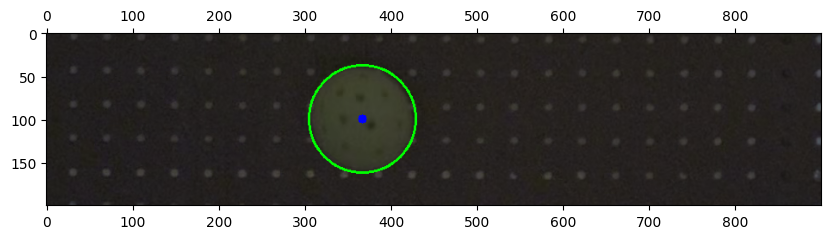

t 1067.7333333333333 ms.  x 967 - y 3129 - radius 62


In [ ]:
# strn = input("frame no")
# print(strn, type(strn), int(strn), type(int(strn)))
# n = int(strn)
view_masked(cap, n)

In [ ]:

# n = input("frame no")
# n = int(n)
# view_masked(cap, n)

In [ ]:
# cap.release()
# cap = cv2.VideoCapture(freefall_path)
# r = True
# t = []
# while r:
#     r,f = cap.read()
#     if r: t.append(cap.get(cv2.CAP_PROP_POS_MSEC))

<Axes: xlabel='time'>

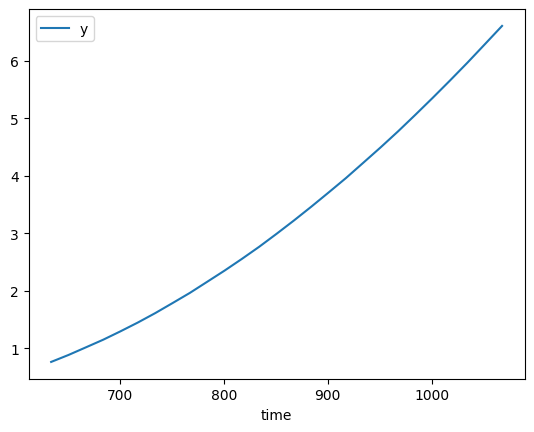

In [ ]:
df.plot(x='time', y='y')

<Axes: xlabel='time'>

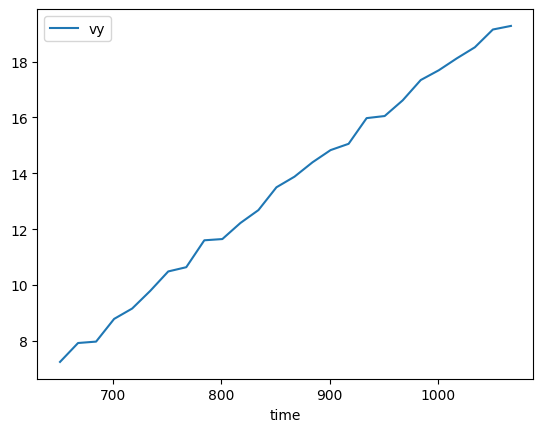

In [ ]:
df.plot(x='time', y='vy')

<Axes: xlabel='time'>

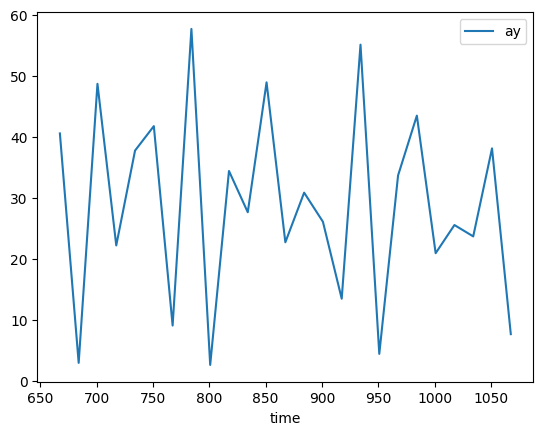

In [ ]:
df.plot(x='time', y='ay')

<Axes: xlabel='time'>

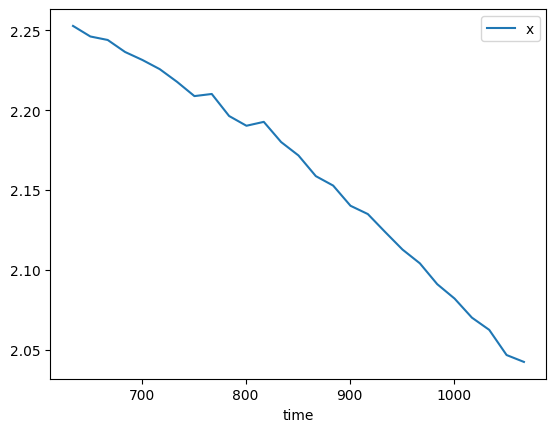

In [ ]:
df.plot(x='time', y='x')

<Axes: xlabel='time'>

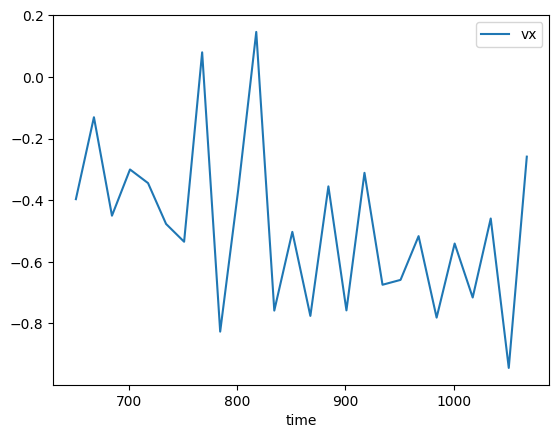

In [ ]:
df.plot(x='time', y='vx')

<Axes: xlabel='time'>

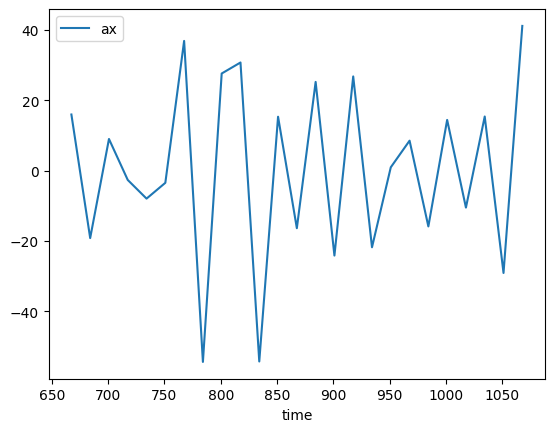

In [ ]:
df.plot(x='time', y='ax')

<Axes: xlabel='time'>

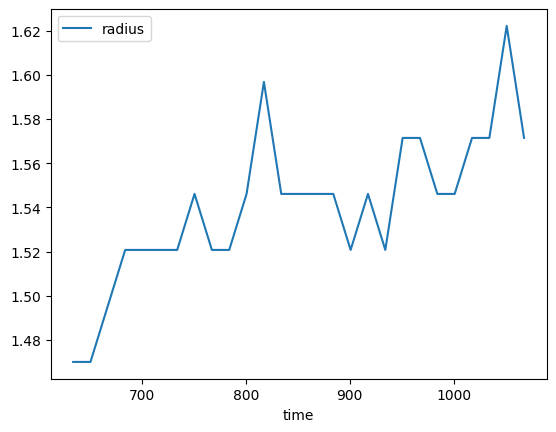

In [ ]:
df.plot(x='time', y='radius')

In [ ]:
df.head(3)


,frame,time,radius,x,y,vx,vy,ax,ay
0,36,633.966667,1.470029,2.252759,0.760117,NaN,NaN,NaN,NaN
1,37,650.650000,1.470029,2.246143,0.881084,-0.396552,7.250778,NaN,NaN
2,38,667.333333,1.495374,2.243963,1.013348,-0.130634,7.927884,15.939191,40.585791


<Axes: xlabel='vy', ylabel='ay'>

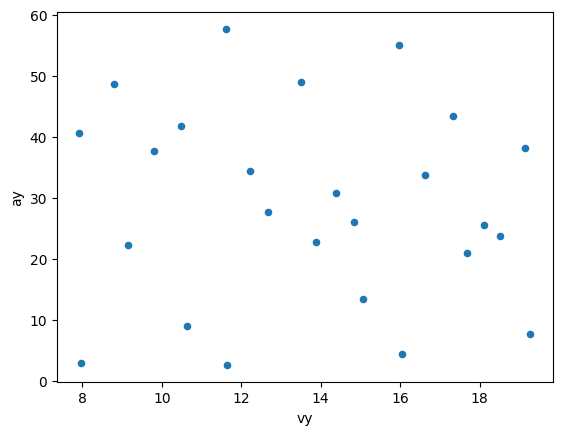

In [ ]:

df.plot.scatter(x='vy', y='ay')

In [ ]:
df.describe()

,frame,time,radius,x,y,vx,vy,ax,ay
count,27.000000,27.000000,27.000000,27.000000,27.000000,26.000000,26.000000,25.000000,25.000000
mean,49.000000,850.850000,1.540433,2.160237,3.240764,-0.484932,13.483465,0.330882,28.831112
std,7.937254,132.419853,0.033956,0.065991,1.804028,0.267823,3.759436,25.859818,16.175229
min,36.000000,633.966667,1.470029,2.042411,0.760117,-0.944153,7.250778,-54.322192,2.653907
25%,42.500000,742.408333,1.520720,2.108433,1.696794,-0.705308,10.526803,-16.347235,20.960772
50%,49.000000,850.850000,1.546065,2.171664,2.990483,-0.489810,13.690601,0.947162,27.672888
75%,55.500000,959.291667,1.558738,2.213949,4.633754,-0.347074,16.472634,15.939191,40.585791
max,62.000000,1067.733333,1.622101,2.252759,6.608795,0.146134,19.275754,41.095267,57.712524


<Axes: >

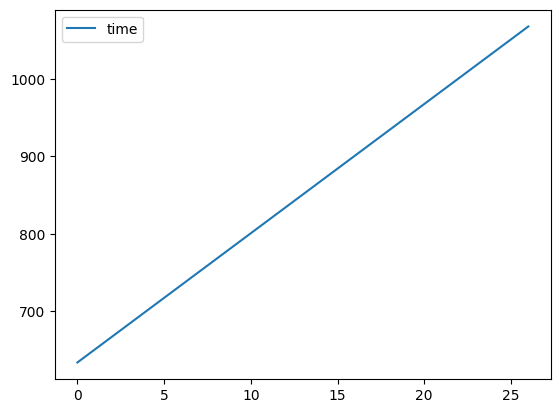

In [ ]:
df.plot(y='time')

In [ ]:
df.head(25).head(10)

,frame,time,radius,x,y,vx,vy,ax,ay
0,36,633.966667,1.470029,2.252759,0.760117,NaN,NaN,NaN,NaN
1,37,650.650000,1.470029,2.246143,0.881084,-0.396552,7.250778,NaN,NaN
2,38,667.333333,1.495374,2.243963,1.013348,-0.130634,7.927884,15.939191,40.585791
3,39,684.016667,1.520720,2.236453,1.146443,-0.450163,7.977716,-19.152595,2.986919
4,40,700.700000,1.520720,2.231445,1.293097,-0.300181,8.790482,8.989937,48.717261
5,41,717.383333,1.520720,2.225699,1.445941,-0.344410,9.161473,-2.651128,22.237241
6,42,734.066667,1.520720,2.217742,1.609300,-0.476945,9.791730,-7.944122,37.777651
7,43,750.750000,1.546065,2.208822,1.784288,-0.534666,10.488819,-3.459806,41.783523
8,44,767.433333,1.520720,2.210155,1.961811,0.079898,10.640756,36.836973,9.107116
9,45,784.116667,1.520720,2.196368,2.155398,-0.826378,11.603593,-54.322192,57.712524


In [ ]:
df.tail(10)

,frame,time,radius,x,y,vx,vy,ax,ay
17,53,917.583333,1.546065,2.134977,3.960851,-0.311130,15.056582,26.750736,13.503895
18,54,934.266667,1.520720,2.123727,4.227390,-0.674286,15.976379,-21.767597,55.132722
19,55,950.950000,1.571410,2.112742,4.495172,-0.658484,16.050853,0.947162,4.463937
20,56,967.633333,1.571410,2.104124,4.772336,-0.516530,16.613228,8.508714,33.708790
21,57,984.316667,1.546065,2.091096,5.061609,-0.780927,17.339045,-15.847948,43.505552
22,58,1001.000000,1.546065,2.082077,5.356716,-0.540562,17.688741,14.407520,20.960772
23,59,1017.683333,1.571410,2.070138,5.658942,-0.715649,18.115460,-10.494744,25.577552
24,60,1034.366667,1.571410,2.062476,5.967769,-0.459250,18.511116,15.368578,23.715648
25,61,1051.050000,1.622101,2.046725,6.287211,-0.944153,19.147361,-29.065147,38.136600
26,62,1067.733333,1.571410,2.042411,6.608795,-0.258547,19.275754,41.095267,7.695868


In [ ]:
df.time.describe()

count      27.000000
mean      850.850000
std       132.419853
min       633.966667
25%       742.408333
50%       850.850000
75%       959.291667
max      1067.733333
Name: time, dtype: float64

In [ ]:
df.y.describe()

count    27.000000
mean      3.240764
std       1.804028
min       0.760117
25%       1.696794
50%       2.990483
75%       4.633754
max       6.608795
Name: y, dtype: float64

In [ ]:
df.vy.describe()

count    26.000000
mean     13.483465
std       3.759436
min       7.250778
25%      10.526803
50%      13.690601
75%      16.472634
max      19.275754
Name: vy, dtype: float64

In [ ]:
df.ay.describe()

count    25.000000
mean     28.831112
std      16.175229
min       2.653907
25%      20.960772
50%      27.672888
75%      40.585791
max      57.712524
Name: ay, dtype: float64

In [ ]:
df.to_csv("../data/freefall.csv", index=False)